In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
sim_info = f'/data01/homes/dipiano/E4/irf_random/crab/map_10s_5sgm/merged_simulator_data.dat'
map_info = f'/data01/homes/dipiano/E4/irf_random/crab/map_10s_5sgm/merged_mapper_data.dat'

# dataset 
filename = '/data01/homes/dipiano/E4/irf_random/crab/clean_50s_5sgm_5000sz_ctools_smooth.npy'
ds = np.load(filename, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Classes: {ds.keys()}\n")
print(f"NOISY dataset size: {len(ds['DS1'])}")
print(f"CLEAN dataset size: {len(ds['DS2'])}")

Classes: dict_keys(['DS1', 'DS2'])

NOISY dataset size: 5000
CLEAN dataset size: 5000


In [2]:
from astroai.tools.utils import split_noisy_dataset

train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=250)

print(f"Train clean: {train_clean.shape}")
print(f"Train noisy: {train_noisy.shape}")
print(f"\nTest clean: {test_clean.shape}")
print(f"Test labenoicyls: {test_noisy.shape}")

Train clean: (4000, 250, 250, 1)
Train noisy: (4000, 250, 250, 1)

Test clean: (1000, 250, 250, 1)
Test labenoicyls: (1000, 250, 250, 1)


In [3]:
sim_data = pd.read_csv(sim_info, sep=' ', header=0).sort_values(by=['seed'])
sim_data.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
6000,crab_00001,1,0,300,300,250.532816,24.000564,250.999454,22.856362,1.221686,North_z40_N_5h_LST,2.5,7.574966
6001,crab_00002,2,0,300,300,310.558216,81.149050,316.719481,81.478464,0.986515,North_z20_50h_LST,2.5,7.451498
6002,crab_00003,3,0,300,300,328.897104,-73.715326,328.558848,-73.222736,0.501902,North_z20_0.5h_LST,2.5,8.754902
6003,crab_00004,4,0,300,300,212.648588,26.526639,211.443397,26.160600,1.140366,North_z60_50h_LST,2.5,7.171744
6004,crab_00005,5,0,300,300,146.452661,38.046145,146.143616,38.000690,0.247660,North_z40_5h_LST,2.5,7.582859


In [4]:
map_data = pd.read_csv(map_info, sep=' ', header=0).sort_values(by=['seed'])
map_data.head()

,name,seed,exposure,center_on,pixelsize,smooth,map_time
8000,crab_00001,1,10,pointing,0.02,5,0.911363
8001,crab_00002,2,10,pointing,0.02,5,1.025839
8002,crab_00003,3,10,pointing,0.02,5,1.349202
8003,crab_00004,4,10,pointing,0.02,5,0.958520
8004,crab_00005,5,10,pointing,0.02,5,1.052539


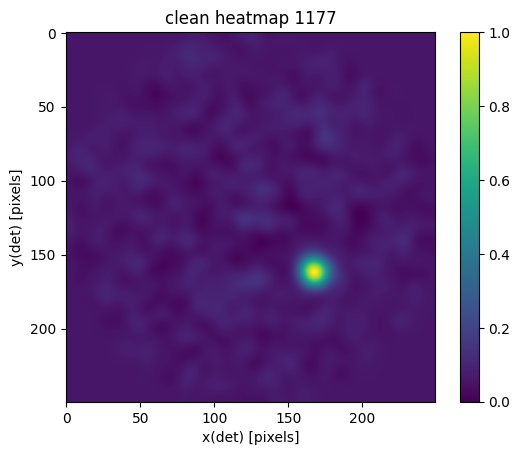

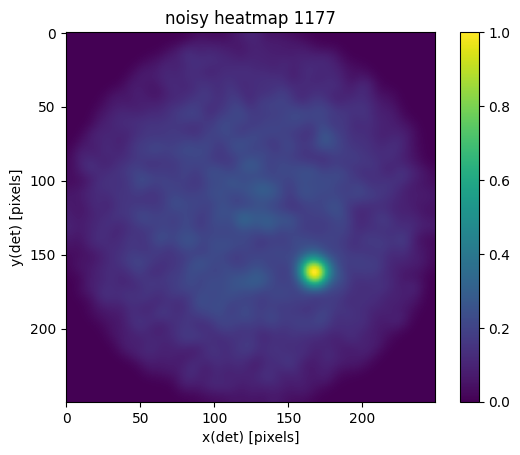

In [5]:
from astroai.tools.utils import plot_heatmap

idx = np.random.choice(range(len(train_clean)))
plot_heatmap(train_clean[idx], title=f'clean heatmap {idx}', show=True, save=False, save_name=None)
plot_heatmap(train_noisy[idx], title=f'noisy heatmap {idx}', show=True, save=False, save_name=None)

## Load model and weights

In [16]:
import tensorflow as tf

model = tf.keras.models.load_model('../models/cleaner_dec1.keras')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 5)       130       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 5)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 5)         630       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 5)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 5)         630   

In [17]:
model.load_weights('../models/checkpoints/cnn_clean_20231221T124633')

32/32 [==============================] - 2s 55ms/step


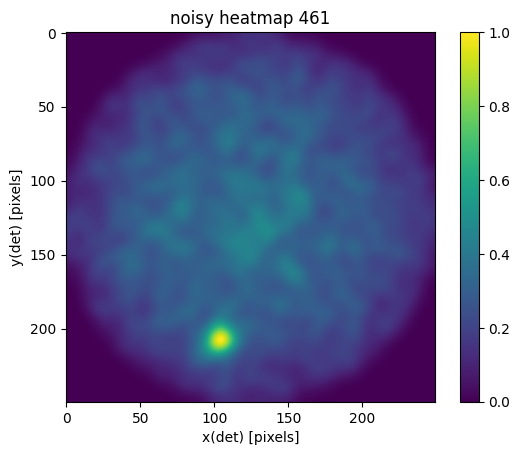

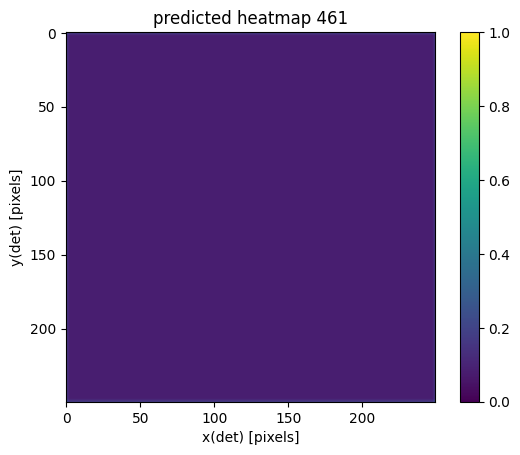

0.24886298

In [20]:
predictions = model.predict(test_noisy)
#print(predictions)

# plot noisy and prediction
idx = np.random.choice(range(len(test_noisy)))
plot_heatmap(test_noisy[idx], title=f'noisy heatmap {idx}', show=True, save=False, save_name=None)
plot_heatmap(predictions[idx], title=f'predicted heatmap {idx}', show=True, save=False, save_name=None)

In [21]:
np.max(predictions[idx]), np.mean(predictions[idx]), np.min(predictions[idx])

(0.24886298, 0.0866461, 0.08480893)

In [11]:
loss, acc = model.evaluate(test_noisy, test_clean, verbose=2)

32/32 - 12s - loss: 0.2862 - accuracy: 1.6000e-05 - 12s/epoch - 368ms/step


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0,1])
ax[0].legend(loc='lower right')

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_ylim([0,1])
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

In [ ]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many plots we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()